# Models de classificació - Càncer de mama

In [2]:
#data exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

#preprocessing libraries
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#model selection and algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score

from tqdm import tqdm
import time

## Exploració de les dades

In [3]:
df = pd.read_csv("train.csv")

df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,10.71,20.39,69.50,344.9,0.10820,0.12890,0.08448,0.02867,0.1668,...,11.69,25.21,76.51,410.4,0.1335,0.2550,0.2534,0.08600,0.2605,0.08701
1,0,13.64,16.34,87.21,571.8,0.07685,0.06059,0.01857,0.01723,0.1353,...,14.67,23.19,96.08,656.7,0.1089,0.1582,0.1050,0.08586,0.2346,0.08025
2,0,11.71,17.19,74.68,420.3,0.09774,0.06141,0.03809,0.03239,0.1516,...,13.01,21.39,84.42,521.5,0.1323,0.1040,0.1521,0.10990,0.2572,0.07097
3,1,15.30,25.27,102.40,732.4,0.10820,0.16970,0.16830,0.08751,0.1926,...,20.27,36.71,149.30,1269.0,0.1641,0.6110,0.6335,0.20240,0.4027,0.09876
4,1,14.45,20.22,94.49,642.7,0.09872,0.12060,0.11800,0.05980,0.1950,...,18.33,30.12,117.90,1044.0,0.1552,0.4056,0.4967,0.18380,0.4753,0.10130


In [5]:
df.shape

(455, 31)

In [7]:
df.dtypes

diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

Aquest dataset conté dades de dones sanes i dones diagnosticades amb càncer de mama, així com certes característiques de cèl·lules que s'han pres durant una punció-aspiració d'agulla fina (PAAF). Recull deu característiques mesurades als nuclis cel·lulars en imatges preses després de la PAAF, que són:
* El radi (la mitjana de les distàncies del centre als punts del perímetre)
* La textura (la desviació estàndar dels valors de la escala de grisos)
* El perímetre
* L'àrea
* L'uniformitat (variació local de les longituts del radi)
* Compacitat ($\frac{perímetre^2}{àrea - 1} \\ $)
* Concavitat (gravetat de les parts còncaves del contorn)
* Punts còncaus (número de parts còncaves del contorn)
* Simetria
* Dimensió fractal

D'aquestes característiques, es recullen al dataset la mitjana (columnes acabades en \_mean), l'error estàndar (columnes acabades en \_se), i el pitjor valor, o el més gran (columnes acabades en \_worst). També es recull el diagnosi, amb un 0 si és benigne, i amb un 1 si és maligne. 
[font](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)

En total, el dataset conté 31 columnes i 455 files. Ara s'explorarà el dataset per saber si hi ha dades faltants i quina es la proporció de diagnosis positives i diagnosis negatives. 

In [8]:
df.isna().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [4]:
features = df.drop("diagnosis", axis = 1)
features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
radius_mean,455.0,14.139000,3.625935,6.981000,11.705000,13.300000,15.740000,28.11000
texture_mean,455.0,19.306286,4.267421,9.710000,16.210000,18.890000,21.795000,39.28000
perimeter_mean,455.0,92.086044,24.998077,43.790000,75.015000,85.980000,103.650000,188.50000
area_mean,455.0,657.829890,363.536865,143.500000,419.250000,546.400000,777.250000,2501.00000
smoothness_mean,455.0,0.096849,0.013981,0.052630,0.086740,0.096860,0.106050,0.16340
compactness_mean,455.0,0.105557,0.052932,0.019380,0.066735,0.094860,0.130450,0.34540
concavity_mean,455.0,0.090775,0.080993,0.000000,0.030180,0.063870,0.132200,0.42680
concave points_mean,455.0,0.049585,0.039159,0.000000,0.020720,0.033840,0.074490,0.20120
symmetry_mean,455.0,0.181319,0.027140,0.116700,0.162050,0.179700,0.195800,0.30400
fractal_dimension_mean,455.0,0.062925,0.007045,0.049960,0.057885,0.061550,0.066375,0.09575


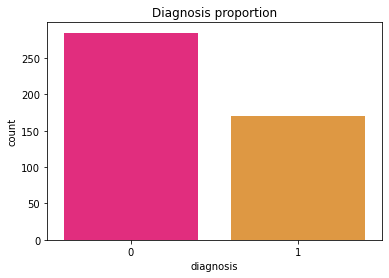

0    285
1    170
Name: diagnosis, dtype: int64

In [47]:
sns.countplot(x = df.diagnosis, palette = ["#ff0f7b", "#f89b29"]).set(
    title = "Diagnosis proportion")
plt.show()
df.diagnosis.value_counts()

No hi ha cap dada faltant, però sí que es troben molts valors atípics al dataset. De totes maneres, és poc probable que siguin dades malament introduides, ja que les cèl·lules canceroses es caracteritzen per tenir trets aberrants. El que indica és que s'haurà de realitzar un escalat de variables que sigui resistent a outliers. 

Així mateix, hi ha una mica de disparitat entre els valors de la variable a predir, però no excessivament. Els diagnòstics malignes de càncer de mama representen un 37% del dataset, i és probable que no calgui fer sobremostreig o submostreig (oversampling/undersampling) per entrenar correctament el model. 

In [15]:
#show multicollinearity in features
def vif(X):
    vifDF = pd.DataFrame()
    vifDF["variables"] = X.columns
    vifDF["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vifDF

vif(features)

,variables,VIF
0,radius_mean,68140.689954
1,texture_mean,275.029682
2,perimeter_mean,62322.593659
3,area_mean,1396.906507
4,smoothness_mean,386.134933
5,compactness_mean,201.658245
6,concavity_mean,166.489708
7,concave points_mean,153.353762
8,symmetry_mean,201.007699
9,fractal_dimension_mean,601.919448


El codi executat a la cel·la superior mostra els factors d'inflació de la variança (VIF) per a cada columna. Quan més alt és aquest valor, es considera que hi ha més colinearitat entre variables, i a partir d'un VIF de 5 hi ha colinearitat. Té sentit que hi hagi colinearitat perquè el dataset recull la mitjana, l'error estàndar i el valor més alt per a una mateixa variable, 10 cops diferents.
Aquest resultat indica que és possible que el rendiment del model es beneficii aplicant-li anàlisi de components principals (PCA).

## Entrenament de models

Es dividirà el dataset en train i test, i s'aplicarà Robust Scaler per escalar les variables. A més, s'aplicarà PCA i s'entrenaran els models amb i sense PCA per avaluar els resultats. Es probaran els algoritmes Random Forest, Regressió Logística, Support Vector Machine i K Neighbors. 

In [11]:
#split into test and train
X_train, X_test, y_train, y_test = train_test_split(features, df.diagnosis, test_size = 0.3, 
                                                    random_state = 8)

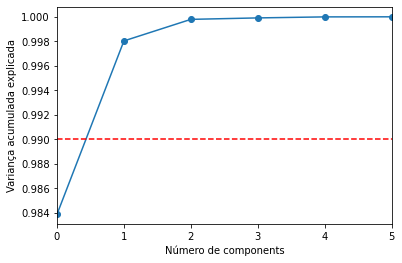

In [20]:
pca = PCA().fit(features)
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker = "o")
plt.axhline(0.99, color = "r", linestyle = "--")
plt.xlim([0, 5])
plt.xlabel("Número de components")
plt.ylabel("Variança acumulada explicada")
plt.show()

Com que hi ha molta colinearitat, es pot agafar només 1 component pel PCA amb més d'un 99% de variança acumulada explicada. 

A continuació, es crearan pipelines per cada possibilitat de model, amb Regressió Logística, K Neighbors, Support Vector Machine i Random Forest, aplicant Robust Scaler i amb i sense PCA. Després s'entrenara en un bucle cada model, s'aplicarà GridSearch per trobar els millors hiperparàmetres i es calcularà la puntuació de validació interna (cross validation). Aquestes dades es guardaran en un dataframe per poder accedir-hi després i poder comparar els resultats per escollir el millor odel per aquest cas. 

In [5]:
models = [
    ("LR", LogisticRegression()),
    ("KNN", KNeighborsClassifier()),
    ("SVM", SVC(random_state = 8, probability = True)),
    ("RF", RandomForestClassifier(max_depth = 3, random_state = 8))
    ]
scalers = [
    ("RobustScaler", RobustScaler())
          ]
pca = [
    ("PCA", PCA(n_components = 1))
      ]

In [6]:
#create pipelines
pipelines = []
#loop for model scaled
for model in models:
    for scalar in scalers:
        model_name = scalar[0] + "_" + model[0]
        pipelines.append((model_name, Pipeline([scalar, model])))

#loop for model scaled and PCA
for model in models:
    for scalar in scalers:
        for p in pca:
            model_name = scalar[0] + "_" + model[0] + "_" + (p[0])
            pipelines.append((model_name, Pipeline([scalar, p, model])))

In [8]:
#logistic regression hyperparameters
C = [x for x in np.arange(0.1, 3, 0.2)]
penalty = ["l2"]
fit_intercept = [True, False]
lr_params = {"LR__C": C,
             "LR__penalty": penalty,
             "LR__fit_intercept": fit_intercept
            }

#kneighbors hyperparameters
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 20, num = 2)]
weights = ["uniform", "distance"]
algorithm = ["auto", "ball_tree", "kd_tree", "brute"]
leaf_size = [int(x) for x in np.linspace(start = 5, stop = 50, num = 2)]
p = [int(x) for x in np.linspace(start = 1, stop = 4, num = 1)]
knn_params = {"KNN__n_neighbors": n_neighbors,
              "KNN__weights": weights,
              "KNN__algorithm": algorithm,
              "KNN__leaf_size": leaf_size,
              "KNN__p": p
             }

#SVM hyperparameters
C = [x for x in np.arange(0.1, 2, 0.2)]
kernel = ["linear", "poly", "rbf", "sigmoid"]
svm_params = {"SVM__C": C,
              "SVM__kernel": kernel
             }

#random forest hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 3, stop = 20, num = 3)]
max_features = ["auto", "sqrt"]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
rf_params = {"RF__n_estimators": n_estimators,
             "RF__max_features": max_features,
             "RF__max_depth": max_depth,
             "RF__min_samples_split": min_samples_split,
             "RF__min_samples_leaf": min_samples_leaf
            }

In [9]:
#dictionary with all the hyperparameters
hypertuned_params = {"LR": lr_params,
                     "KNN": knn_params,
                     "SVM": svm_params,
                     "RF": rf_params
                    }

In [12]:
# list that contains the rows for the dataframe
rows_list = []

#lists for the pipeline results
results = []
names = []
test_scores = []
parameters = []

#for gridsearch and cross validation score 
cv = KFold(n_splits = 5)
with tqdm(total = 100) as pbar:
    for name, model in pipelines:

        #get model names
        model_name = name.split("_")[1]
        if "-" in model_name:
            model_name = model_name.split("-")[0]
        #get hyper parameters
        if model_name in hypertuned_params.keys():
            random_grid = hypertuned_params[model_name]
        else:
            continue

        #train nested cross validation and gridsearch
        clf = GridSearchCV(estimator = model, param_grid = random_grid, cv = cv, scoring = "f1_macro",
                           error_score = "raise")
        clf.fit(X_train, y_train)
        cv_results = cross_val_score(clf, X_train, y_train, cv = cv, scoring = "f1_macro")
        results.append(cv_results)
        names.append(name)
        parameters.append(clf.best_params_)

        #print cross validation results of the best classifier
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

        #fit on train and predict on test
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        curr_test_score = f1_score(y_test, y_pred, average = "macro")
        test_scores.append(curr_test_score)

        #add to dictionary for final dataframe
        results_dict = {"Classifier_Name": name,
                        "CV_mean": cv_results.mean(),
                        "CV_std": cv_results.std(),
                        "F1_score": curr_test_score,
                        "Parameters": parameters,
                       }
        rows_list.append(results_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

RobustScaler_LR: 0.966494 (0.020532)
RobustScaler_KNN: 0.921223 (0.031340)
RobustScaler_SVM: 0.945030 (0.020084)
RobustScaler_RF: 0.919959 (0.039313)
RobustScaler_LR_PCA: 0.884684 (0.043068)
RobustScaler_KNN_PCA: 0.891316 (0.038900)
RobustScaler_SVM_PCA: 0.884985 (0.026976)


  0%|          | 0/100 [21:46<?, ?it/s]

RobustScaler_RF_PCA: 0.892797 (0.038950)


In [13]:
#create dataframe with dictionary content
df_results = pd.DataFrame(rows_list)

In [14]:
#save to csv to access it later
df_results.to_csv("results_f1.csv")

## Selecció de model

In [22]:
df_results.drop(["Parameters"], axis = 1)

,Classifier_Name,CV_mean,CV_std,F1_score
0,RobustScaler_LR,0.966494,0.020532,0.969623
1,RobustScaler_KNN,0.921223,0.031340,0.946678
2,RobustScaler_SVM,0.945030,0.020084,0.969623
3,RobustScaler_RF,0.919959,0.039313,0.946332
4,RobustScaler_LR_PCA,0.884684,0.043068,0.907014
5,RobustScaler_KNN_PCA,0.891316,0.038900,0.891516
6,RobustScaler_SVM_PCA,0.884985,0.026976,0.899634
7,RobustScaler_RF_PCA,0.892797,0.038950,0.899634


In [15]:
#get row with highest f1 score 
df_results.loc[df_results["F1_score"].idxmax()]

Classifier_Name                                      RobustScaler_LR
CV_mean                                                     0.966494
CV_std                                                      0.020532
F1_score                                                    0.969623
Parameters         [{'LR__C': 0.30000000000000004, 'LR__fit_inter...
Name: 0, dtype: object

Els resultats sense aplicar PCA són superiors en tots els casos. Com que l'objectiu del model és aconseguir el F1 macro més alt, el model amb Regressió Logística i el model amb Support Vector Machine semblen els millors. De totes maneres, l'indicador de cross validation és més alt en el cas de la Regressió Logística, i aquest sembla el millor model. Ara es reentrenara amb totes les dades del train.csv per poder predir els diagnostics del test.csv millor.

## Model final

In [32]:
#gridsearch for the definitive model
clf = GridSearchCV(estimator = pipelines[0][1], param_grid = lr_params, cv = cv, scoring = "f1_macro")

#retrain with all the data
result = clf.fit(features, df.diagnosis)

In [33]:
print("F1 macro: ", result.best_score_.round(4))

F1 macro:  0.9738


La mètrica F1 macro ha augmentat després de reentrenar el model amb totes les dades, el que és una bona senyal. 

In [44]:
#read test file
df2 = pd.read_csv("test.csv")

#predict target on test data
prediction = clf.predict(df2)

#create dataframe with predictions
pred_df = pd.DataFrame(data = prediction, columns = ["diagnosis"])

#save as csv 
pred_df.to_csv("predictions.csv")